In [2]:
import pandas as pd
import plotly as pl
import plotly.express as px
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import make_column_transformer
from sklearn.cluster import AffinityPropagation, DBSCAN, Birch
from sklearn.metrics import davies_bouldin_score
from sklearn.metrics import calinski_harabasz_score
import numpy as np
import math
from collections import Counter
import seaborn as sns
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
DATA = pd.read_csv("online_shoppers_intention.csv")


Task 1: Get data on screen
Goal: Make visualizations that help understand the data

In [3]:
# New- vs. Returning customers pie chart

DATAvis = DATA
fig = px.pie(DATAvis, names='VisitorType', title='Types of Customers')
fig.update_layout(width=500)
fig.show()



# DURATION BOX PLOTTED
# Product related has a couple (<10) extreme outliers, had to filter those out
threshold = 10000 

filtered_data = DATA[
    (DATA['Administrative_Duration'] <= threshold) &
    (DATA['Informational_Duration'] <= threshold) &
    (DATA['ProductRelated_Duration'] <= threshold)
]

# Create a copy of the filtered data with better named columns
filtered_data_renamed = filtered_data.rename(columns={
    'Administrative_Duration': 'Administrative Duration',
    'Informational_Duration': 'Informational Duration',
    'ProductRelated_Duration': 'Product Related Duration'
})

fig = px.violin(filtered_data_renamed, y=['Administrative Duration', 'Informational Duration', 'Product Related Duration'])
fig.update_layout(
    title="Duration of Activities (Filtered)",
    yaxis_title="Duration (Seconds)",  
    xaxis_title='Variable',
    width=500  
)
fig.show()

# BOUNCERATES VS EXITRATES scatter
fig = px.scatter(DATAvis, x="BounceRates", y="ExitRates")
fig.update_layout(
    title="Bounce Rates vs Exit Rates",
    yaxis_title="Exit rates",  
    xaxis_title='Bounce Rates',
    width=500  
)
fig.show()


## PAGEVALUES PER MONTH
monthly_average = DATAvis.groupby('Month')['PageValues'].mean().reset_index()
# Create the line chart
fig = px.line(monthly_average, y="PageValues", x="Month", title="Average Page Values by Month")
fig.update_layout(
    yaxis_title="Page Values",  
    xaxis_title='Month',
    width=700  
)
fig.show()


# EXITRATES PER TRAFFICTYPE
fig = px.bar(DATAvis, x="TrafficType", y="ExitRates",
             color='TrafficType', barmode='stack',
             height=400)
fig.update_layout(
    yaxis_title="Exit Rates",  
    xaxis_title='Traffic Type',
    width=700  
)
fig.show()

purchase_counts = DATAvis[DATAvis['Revenue']].groupby('Month').size().reset_index(name='Count')

fig = px.bar(purchase_counts, x='Month', y='Count', title='Count of Purchases by Month')
fig.update_layout(
    width=700  
)
fig.show()

# PURCHASES CLOSE TO IMPORTANT DATES
SD_purchase_data = DATAvis[DATAvis['Revenue']]

SD_purchase_counts = SD_purchase_data['SpecialDay'].value_counts().reset_index()
SD_purchase_counts.columns = ['SpecialDay', 'Count']

SD_purchase_counts = SD_purchase_counts.sort_values('SpecialDay')

fig = px.line(SD_purchase_counts, x='SpecialDay', y='Count', title='Count of Purchases by Days to Special Day')
fig.update_layout(
    width=700  
)
fig.update_layout(xaxis=dict( autorange="reversed"))

fig.show()


browser_13_data = DATAvis[DATAvis['Browser'] == 13]
other_browser_data = DATAvis[DATAvis['Browser'] != 13]

DATAvis['BrowserType'] = DATAvis['Browser'].apply(lambda x: 'Browser 13' if x == 13 else 'Other Browsers')

fig = px.bar(DATAvis.groupby('BrowserType')['Revenue'].mean().reset_index(),
             x='BrowserType', y='Revenue', title='Proportion of Purchases: Browser 13 vs Other Browsers')
fig.update_layout(
    width=700,
    yaxis_title="Revenue",  
    xaxis_title='Type of Browser',
)

fig.show()



overall_summary = DATAvis.agg({
    'BounceRates': ['mean', 'median'],
    'ExitRates': ['mean', 'median'],
    'PageValues': ['mean', 'median'],
    'Administrative_Duration': ['mean', 'median'],
    'Informational_Duration': ['mean', 'median'],
    'ProductRelated_Duration': ['mean', 'median'],
    'SpecialDay': ['mean', 'median'],
}).reset_index()


browser_13_data = DATAvis[DATAvis['Browser'] == 13]
browser_13_summary = browser_13_data.agg({
    'BounceRates': ['mean', 'median'],
    'ExitRates': ['mean', 'median'],
    'PageValues': ['mean', 'median'],
    'Administrative_Duration': ['mean', 'median'],
    'Informational_Duration': ['mean', 'median'],
    'ProductRelated_Duration': ['mean', 'median'],
    'SpecialDay': ['mean', 'median'],
}).reset_index()

print("This is the overall summary:")
print(overall_summary)
print("This is the browser 13 summary")
print(browser_13_summary)


page_values_data = pd.DataFrame({
    'User Type': ['Overall'] + ['Browser 13'],
    'Page Values': [5.889258, 26.268249],
})

fig_page_values = px.bar(page_values_data, x='User Type', y='Page Values', 
                         title='Mean Page Values for Overall Users and Browser 13',
                         width = 700)

fig_page_values.show()

fig = px.box(DATAvis, y=['Administrative_Duration', 'Informational_Duration'], 
             color='BrowserType',
             title='Box Plots of Duration Metrics: Browser 13 vs Other Browsers')

fig.update_layout(
    yaxis_title="Duration (Seconds)",
    xaxis_title="Duration Type",
    yaxis_range=[0, 500],
    width=800
)
fig.show()

fig = px.box(DATAvis, y=['ProductRelated_Duration'], 
             color='BrowserType',
             title='Box Plot of Product Related Duration: Browser 13 vs Other Browsers')

fig.update_layout(
    yaxis_title="Duration (Seconds)",
    xaxis_title="Duration Type",
    width=800,
    yaxis_range=[0,5000]
)
fig.show()

This is the overall summary:
    index  BounceRates  ExitRates  PageValues  Administrative_Duration  \
0    mean     0.022191   0.043073    5.889258                80.818611   
1  median     0.003112   0.025156    0.000000                 7.500000   

   Informational_Duration  ProductRelated_Duration  SpecialDay  
0               34.472398              1194.746220    0.061427  
1                0.000000               598.936905    0.000000  
This is the browser 13 summary
    index  BounceRates  ExitRates  PageValues  Administrative_Duration  \
0    mean     0.034373   0.052842   26.268249                 73.71653   
1  median     0.000000   0.025000    0.000000                  0.00000   

   Informational_Duration  ProductRelated_Duration  SpecialDay  
0                4.717486               699.388395         0.0  
1                0.000000               302.000000         0.0  


There are no missing values in the dataset
Index(['Month_Aug', 'Month_Dec', 'Month_Feb', 'Month_Jul', 'Month_June',
       'Month_Mar', 'Month_May', 'Month_Nov', 'Month_Oct', 'Month_Sep',
       'OperatingSystems_1', 'OperatingSystems_2', 'OperatingSystems_3',
       'OperatingSystems_4', 'OperatingSystems_5', 'OperatingSystems_6',
       'OperatingSystems_7', 'OperatingSystems_8', 'Browser_1', 'Browser_2',
       'Browser_3', 'Browser_4', 'Browser_5', 'Browser_6', 'Browser_7',
       'Browser_8', 'Browser_9', 'Browser_10', 'Browser_11', 'Browser_12',
       'Browser_13', 'Region_1', 'Region_2', 'Region_3', 'Region_4',
       'Region_5', 'Region_6', 'Region_7', 'Region_8', 'Region_9',
       'TrafficType_1', 'TrafficType_2', 'TrafficType_3', 'TrafficType_4',
       'TrafficType_5', 'TrafficType_6', 'TrafficType_7', 'TrafficType_8',
       'TrafficType_9', 'TrafficType_10', 'TrafficType_11', 'TrafficType_12',
       'TrafficType_13', 'TrafficType_14', 'TrafficType_15', 'TrafficType_16',

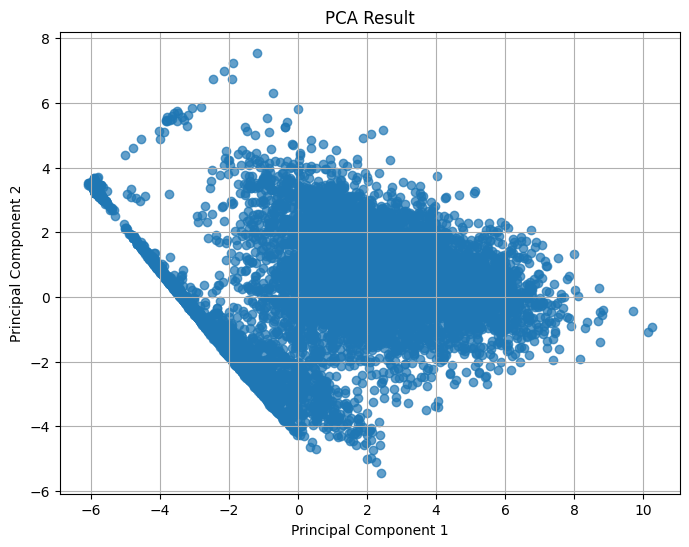

In [4]:

# cleaning

cleaneddata = DATA.dropna()
if len(DATA)-len(cleaneddata) == 0:
    print("There are no missing values in the dataset")

#candidates for one-hot-encoding (OHE)
featuresOHN = ['Month', 'OperatingSystems', 'Browser', 'Region', 'TrafficType', 'VisitorType']
cleaneddata[featuresOHN] = cleaneddata[featuresOHN].astype(str)
transformer = make_column_transformer((OneHotEncoder(categories='auto', sparse_output=False), featuresOHN), remainder='passthrough')
transformed = transformer.fit_transform(DATA)
df = pd.DataFrame(transformed, columns=transformer.get_feature_names_out())

# clean column names for readability
flist = df.columns.to_list()
newflist = [col.replace('remainder__', '') if col.startswith('remainder__') else col.replace('onehotencoder__', '') for col in flist]
df.columns = newflist

# Assuming df is your DataFrame
print(df.columns)

boolcolumns = ['Weekend','Revenue']
for column in boolcolumns:
    cleaneddata[column] = cleaneddata[column].replace({'TRUE': 1, 'FALSE': 0})
    df[column] = df[column].replace({'TRUE': 1, 'FALSE': 0})
print(cleaneddata.columns)


encodedcolumns = ['OperatingSystems','Browser','Region','TrafficType','BrowserType']

dropencoded = False
for column in encodedcolumns:
    if dropencoded:
        df = df.drop(columns=[column])

#df = df.drop(columns=['Month','VisitorType'])
df = df.drop(columns=['BrowserType'])


# data normalization
featuresMinMax = ['BounceRates', 'ExitRates']
featuresZscore = ['Administrative', 'Administrative_Duration', 'Informational', 'Informational_Duration', 'ProductRelated', 'ProductRelated_Duration', 'PageValues']

for f in featuresMinMax:
    df[f] = (df[f] - df[f].min()) /(df[f].max() - df[f].min())

for f in featuresZscore:
    df[f] = df[f].astype(float)
    df[f] = np.log1p(df[f])

# Applying PCA
pca = PCA(n_components=2)  # Adjust the number of components as needed
pca_result = pca.fit_transform(df)

# Create a DataFrame for PCA results
pca_df = pd.DataFrame(data=pca_result, columns=['PC1', 'PC2'])

# Print the explained variance ratio
print("Explained Variance Ratio:", pca.explained_variance_ratio_)
print("PCA Result Head:\n", pca_df.head())

# If you want to visualize the PCA results


plt.figure(figsize=(8, 6))
plt.scatter(pca_df['PC1'], pca_df['PC2'], alpha=0.7)
plt.title('PCA Result')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.grid()
plt.show()



#Take a random sample from the dataset which can be used for complexer models which do not scale well
df_sample = df.sample(frac = 0.35)


Task 3: Clustering Algorithms
Goal: Succesfully use clustering algorithms

In [4]:
# Affinity Propagation, different blocks to test each clustering algorithm separately
affinity_propagation = AffinityPropagation(random_state=27)
num_features = df_sample.shape[1]
print(f"Number of features: {num_features}")

affinity_propagation.fit(df_sample)

affinity_labels = affinity_propagation.labels_

# Affinity Propagation information
print(affinity_propagation.cluster_centers_)
print(affinity_labels)
print(affinity_propagation.n_iter_)

Number of features: 75
[[0.  0.  0.  ... 0.  0.  0. ]
 [0.  0.  0.  ... 0.  0.  0. ]
 [0.  0.  0.  ... 0.  1.  0. ]
 ...
 [0.  0.  0.  ... 0.6 0.  0. ]
 [0.  0.  0.  ... 0.  0.  0. ]
 [0.  0.  0.  ... 0.  0.  1. ]]
[103 102 112 ...  39 113  45]
48


In [5]:
#DBSCAN, different blocks to test each clustering algorithm separately
dbscan = DBSCAN(eps=0.75, min_samples=10)
dbscan.fit(df)
dbscan_labels = dbscan.labels_

[-1 -1 -1 ... -1 -1 -1]


In [6]:
# BIRCH, different blocks to test each clustering algorithm separately
birch = Birch(threshold=0.75, n_clusters=None)
birch.fit(df)
birch_labels = birch.labels_

Task 4: Evaluation of clustering methods
Goal: Be able to evaluate clustering methods using different evaluation measures and reason on their performance

In [7]:
#############################
# Task 4.1: Silhoutte score #
#############################

# a(i) = 1 / |Ci| - 1 * sum d(i,j), 1 divided by the amount in the cluster times the sum of all distances
# between i and all other values in the cluster
print(birch_labels)



# Function to calculate distances to the current cluster
def distances_to_cluster(point_index, data, all_labels, current_label):
    # Get the indices of all points in the same cluster
    cluster_indices = np.where(all_labels == current_label)[0]
    
    point = data.iloc[point_index].values
    
    cluster_data = data.iloc[cluster_indices].values

    cluster_data = cluster_data.astype(float)
    point = point.astype(float)

    distances = np.linalg.norm(cluster_data - point, axis=1)
    
    return distances


# Silhouette score calculation
def calc_silhoutte_score(labels):
    silhouette_scores = []
    
    for id, point in pca_df.iterrows():
        
        # Calculating a(i) - mean intra-cluster distance
        current_label = labels[id]
        cluster_indices = np.where(labels == current_label)[0]
        cluster_size = len(cluster_indices)
        
        
        if cluster_size < 2:
            silhouette_scores.append(0)
            continue
        
        # Sum of distances within the same cluster
        sum_of_distances = distances_to_cluster(id, pca_df, labels, current_label)
        current_ai = (1 / (cluster_size - 1)) * np.sum(sum_of_distances)
        
        list_of_bi = []
        
        # Calculating b(i) - minimum average distance to other clusters
        for other_label in np.unique(labels):
            if other_label != current_label:
                other_cluster_indices = np.where(labels == other_label)[0]
                other_cluster_size = len(other_cluster_indices)
                
                if other_cluster_size == 0:
                    continue
                
                # Distance to points in other clusters
                other_cluster_dists = distances_to_cluster(id, pca_df, labels, other_label)
                current_bi = np.mean(other_cluster_dists)
                list_of_bi.append(current_bi)
        
        if list_of_bi:
            bi = min(list_of_bi)
        else:
            bi = float('inf')  
        
        # Calculating the silhouette score for the current point
        if max(current_ai, bi) > 0:
            silhouette_score = (bi - current_ai) / max(current_ai, bi)
        else:
            silhouette_score = 0
        
        silhouette_scores.append(silhouette_score)
    
    # Return the mean silhouette score, ignore NaNs if present
    return np.nanmean(silhouette_scores)


# affin_sil_score = calc_silhoutte_score(affinity_labels)
#birch_sil_score = calc_silhoutte_score(birch_labels)
#print(birch_sil_score)
#dbscan_sil_score = calc_silhoutte_score(dbscan_labels)
#print(dbscan_sil_score)





        







[ 838   28  839 ... 9483 3235  155]


In [8]:
# SILLHOUETTE SCORE

first_1000_rows = df[:10]


def euclidean_distance(row1, row2):
    return np.sqrt(np.sum((row1 - row2) ** 2))


def silhouette_score(labels):

    unique_clusters = np.unique(labels)
    num_clusters = len(unique_clusters)

    for index, row in first_1000_rows.iterrows():
        print("ploink")
        current_cluster = birch_labels[index]
        Ci = list(labels).count(current_cluster)

        own_clust_dist = 0

        for index2, row2 in first_1000_rows.iterrows():
            if birch_labels[index2] == current_cluster and index2 != index:
                dist = euclidean_distance(row,row2)
                own_clust_dist += dist
        
        if Ci > 1:
            Ai = (1 / (Ci - 1)) * own_clust_dist
        else:
            Ai = 0

        min_distance = float('inf')  # Initialize minimum distance as infinity
        
        for j in range(num_clusters - 1):
            other_clust = unique_clusters[j]
            if other_clust != current_cluster:
                distance_sum = 0
                for index3,row3 in first_1000_rows.iterrows():
                    if labels[index3] == other_clust:
                        distance_sum = euclidean_distance(row, row3)
                average_dist = distance_sum / list(labels).count(other_clust)
                if average_dist < min_distance:
                    min_distance = average_dist
                    neighboring_cluster = unique_clusters[j]
        Bi = min_distance
        
        if Ci > 1 and Bi != 0 and Ai != 0:
            Si = (Bi - Ai) / max(Bi,Ai)
        else:
            Si = 0
        
    return Si
         

birch_sil_score = silhouette_score(birch_labels)
print("The silhouette score for the birch clusterin algorithm is:", birch_sil_score)
dbscan_sil_score = silhouette_score(dbscan_labels)
print("The silhouette score for the dbscan clusterin algorithm is:", dbscan_sil_score)
affinity_sil_score = silhouette_score(affinity_labels)
print("The silhouette score for the affinity propagation clusterin algorithm is:", affinity_sil_score)

ploink
ploink
ploink
ploink
ploink
ploink
ploink
ploink
ploink
ploink
ploink
ploink
ploink
ploink
ploink
ploink
ploink
ploink


In [20]:
# TASK 4.2 - Davies Bouldin Score
# minimum score is 0, with lower numbers indicating better clustering

birch_bouldin_score = davies_bouldin_score(df, birch_labels)
dbscan_bouldin_score = davies_bouldin_score(df, dbscan_labels)
affinity_bouldin_score = davies_bouldin_score(df, affinity_labels)

print("Davies Bouldin score for birch clustering:", birch_bouldin_score)
print("Davies Bouldin score for DBScan clustering:", dbscan_bouldin_score)
print("Davies Bouldin score for affinity propagation clustering:", affinity_bouldin_score)

dic = {birch_bouldin_score: "birch", dbscan_bouldin_score: "DBScan" , affinity_bouldin_score: "affinity propagation"}

print("The lowest score is the best result")
print("The best scoring algorithm is the", dic[min(birch_bouldin_score, dbscan_bouldin_score, affinity_bouldin_score)], "clustering algorithm")

Davies Bouldin score for birch clustering: 0.40888715403374226
Davies Bouldin score for DBScan clustering: 1.1589674373010297
The lowest score is the best result
The best scoring algorithm is the birch clustering algorithm


In [19]:
# TASK 4.3 - Calinski Harabasz Score
# higher scores indicate better clustering

birch_harabasz_score = calinski_harabasz_score(df, birch_labels)
dbscan_harabasz_score = calinski_harabasz_score(df, dbscan_labels)
affinity_harabasz_score = calinski_harabasz_score(df, affinity_labels)

print("Calinski Harabasz score for birch clustering:", birch_harabasz_score)
print("Calinski Harabasz score for DBScan clustering:", dbscan_harabasz_score)
print("Calinski Harabasz score for affinity propagation clustering:", affinity_harabasz_score)

dic1 = {birch_harabasz_score: "birch", dbscan_harabasz_score: "DBScan", affinity_harabasz_score: "affinity propagation"}

print("The highest score is the best result")
print("The best scoring algorithm is the", dic1[max(birch_harabasz_score, dbscan_harabasz_score, affinity_harabasz_score)], "clustering algorithm")

Calinski Harabasz score for birch clustering: 44.46590443447023
Calinski Harabasz score for DBScan clustering: 18.1077352572329
The highest score is the best result
The best scoring algorithm is the birch vlustering algorithm


In [ ]:
# 5.1: Manual Euclidian Distance
def manual_euclidean_distance(p1, p2):

    distance = 0.0
    
    for i in range(len(p1)):
        distance += (p1[i] - p2[i]) ** 2
    
    return distance ** 0.5


# 5.2: Manual Manhatten Distance
def manual_manhattan_distance(p1, p2):
    distance = 0.0
    
    for i in range(len(p1)):
        distance += abs(p1[i] - p2[i])
    
    return distance


# 5.3: Manual 
def cosine_similarity_distance(p1, p2):
    dot_product = sum(a * b for a, b in zip(p1, p2))
    magnitude_p1 = math.sqrt(sum(a**2 for a in p1))
    magnitude_p2 = math.sqrt(sum(b**2 for b in p2))
    
    if magnitude_p1 == 0 or magnitude_p1 == 0:
        return 0  
    
    cos_similarity = dot_product / (magnitude_p1 * magnitude_p2)

    return 1 - cos_similarity

